# Euler Bend

> optimizing a waveguide bend

In [ ]:
#| default_exp eulerbend


The question states:
> What’s the minimum bend radius for an euler bend for 400nm thick silicon for 1um wide waveguides at 1550nm for TE polarization. What’s the optimal radius and p parameter?

Let's first get an intuition for the modes supported by a 400nmx1um silicon waveguide

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
from skill_challenge.util import np, gf, gt, plt, nm, cachedComputeModes

[15:12:18] WARNING: Mode field at frequency index 0, mode index 11 does not decay at the plane   ]8;id=936104;file:///root/miniconda3/lib/python3.10/site-packages/tidy3d/plugins/mode/mode_solver.py\mode_solver.py]8;;\:]8;id=992359;file:///root/miniconda3/lib/python3.10/site-packages/tidy3d/plugins/mode/mode_solver.py#428\428]8;;\
           boundaries.                                                                                             

[3.11257216+7.32843736e-06j 2.92860407+2.48656630e-05j
 2.82713474+1.55401589e-05j 2.69195954+3.11270123e-05j
 2.29838515+4.27650747e-05j 2.28191374+4.23492723e-05j
 2.18429146+4.41482052e-05j 1.72940619+9.42212267e-05j
 1.65737157+7.71399957e-05j 1.64125925+1.71944180e-04j
 1.46231259+2.17033188e-04j 1.43783098+2.13876809e-04j]


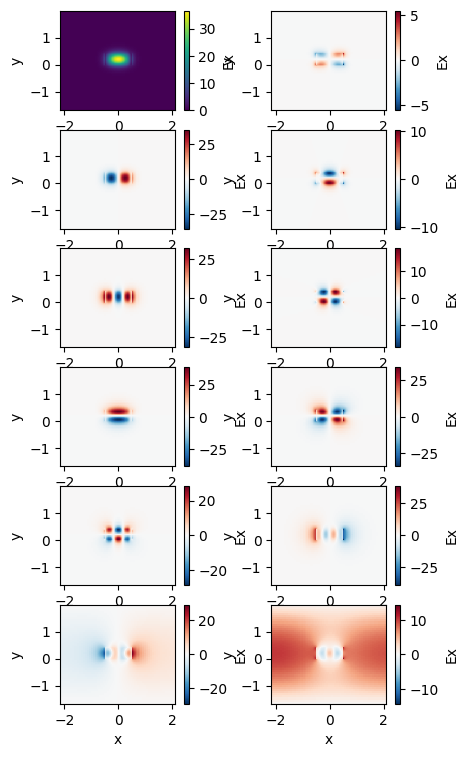

In [ ]:
num_modes = 12
strip = gt.modes.Waveguide(
    wavelength=1.55,
    core_width=1.0,
    slab_thickness=0.0,
    core_material="si",
    clad_material="sio2",
    core_thickness=400 * nm,
    num_modes=num_modes,
)

light_line = 1.44

fig, axs = plt.subplots(num_modes//2, 2, figsize=(5, 1.5*num_modes//2))
for m, ax in enumerate(axs.flatten()):
    strip.plot_field("Ex", mode_index=m, ax=ax)
print(strip.n_eff)

Note that the given waveguide geometry supports 11 modes. 5 of which are qTE.

To me the question is somewhat unclear. Therefore I will try to amend the question in the way I belive it was intended:

What’s the minimum bend radius for an euler bend for 400nm thick silicon for 1um wide waveguides at 1550nm for TE polarization, so that the fundamental mode has a transmission penalty of less then 0.01dB. What’s the optimal p parameter at a given effective radius to minimize that transmission penalty?


## But: Mode Mixing losses
The waveguide at hand is highly multimode. The loss of the fundamental mode will thus be dominated by coupling to higher order modes instead of radiative loss as it is the case for single mode waveguides. Thus we need a different simulation approach. FDTD/FDFD is computationally to expensive for the large simulatio volumes we require here. Thus I opt to use eigenmode expansion (eme) in a similar fashion as was used in the paper [Analysis of silicon nitride partial Euler waveguide bends](https://opg.optica.org/oe/fulltext.cfm?uri=oe-27-22-31394&id=422321).
To realize that I will be using the opensource eme framework [meow](https://github.com/flaport/meow). To capture the bend geometry a straight structure was used and the eme-cells were augmented with the bend radius at the corresponding position.

To speed up the simulation time of successive sweep points the modes were cached. The positions of the eme-cells was carefully chosen to maximize the mode reuse. A modified version of this script will be uploaded to the meow repo as an example. It is based on a prototype by Floris Laporte.

In [ ]:
from functools import lru_cache

import matplotlib.pyplot as plt
import meow as mw

import numpy as np
from scipy.special import fresnel
from tqdm.notebook import tqdm
from typing import Optional

eps = np.finfo(np.float64).resolution

In [ ]:
#@title Settings
T = 38.0        #@param {type:"number"}  #Temperature in deg C
wl_start = 1.5  #@param {type:"number"}  #Start wavelength in um
wl_stop = 1.6   #@param {type:"number"}  #Stop wavelength in um
num_wl = 5      #@param {type:"number"}  #number of wavelengths
w = 1           #@param {type:"number"}  #waveguide width in um
t_slab = 0      #@param {type:"number"}  #slab thickness in um
t_core = 0.400  #@param {type:"number"}  #core thickness in um
t_ox = 3        #@param {type:"number"}  #cladding thickness in um; full extend
num_modes = 7   #@param {type:"number"}  #number of considered modes
num_cells = 35  #@param {type:"number"}  #number of cells in eme
n_wg = 3.45     #@param {type:"number"}  #refractive index of the core
n_ox = 1.46     #@param {type:"number"}  #refrective index of the cladding
alpha_tot = np.pi/2 #angle of the full turn
R_eff =  140     #@param {type:"number"}  #effective Radius in um

R_eff_min = 130  #@param {type:"number"}  #minimum effective Radius in sweep
R_eff_max = 400 #@param {type:"number"}  #maximum effective Radius in sweep
R_eff_points = 10
R_eff_sweep = np.logspace(
    np.log10(R_eff_min), 
    np.log10(R_eff_max), 
    R_eff_points)

p = 0.5         #@param {type:"number"}  #part of the bend that is euler
p_sweep = np.logspace(np.log10(0.01), np.log10(0.25), 60)

wl_mean = np.mean([wl_start, wl_stop])

## Euler Bend Intro

As we want to use `scipy.special.fresnel` to evaluate the fresnel integrals, we have to express the cos/sin argument as $\frac{\pi t^2}{2}$ while it is $\frac{t^2}{2R_0^2}$ in the euler spiral. Thus let's chose $R_0 = 1/\sqrt{\pi}$

In [ ]:
def R_0() -> float:
  """reference radius for use in fresnel integral"""
  return 1/np.sqrt(np.pi)

From the paper we know that we have to trace the path up to $s(\alpha) = R_0\sqrt{2\alpha}$ (eq. 3)
thus to the end of the first euler section we find.
Note: The angle at the end of the first euler part is $p\alpha_{tot}/2$

In [ ]:
def s_p(R_0:float, alpha_tot: float, p: float):
  """path length at interface between euler and circular bend"""
  return R_0*np.sqrt(p*alpha_tot)

The radius of the circular section (unscaled) $R_p = \frac{R_0}{2\sqrt{p\alpha/2}}$
Note: this formula was found to not lead to the correct results. The corrected formula was taken from the `gdsfactory` euler bend implementation:
$$R_p = \frac{R_0}{\sqrt{p\alpha}}$$

In [ ]:
def R_p(R_0:float, alpha_tot: float, p: float):
  """radius of the circular bend"""
  return R_0/np.sqrt(p*alpha_tot)

The total bend lengths results as:

In [ ]:
def s_0(s_p:float, R_p:float, alpha_tot: float, p: float):
  """total path length of the partial euler bend"""
  return 2*s_p + R_p*alpha_tot*(1-p)

In [ ]:
def eval_params(alpha_tot: float, p: float):
  _R_0 = R_0()
  _s_p = s_p(_R_0, alpha_tot, p)
  _R_p = R_p(_R_0, alpha_tot, p)
  _s_0 = s_0(_s_p, _R_p, alpha_tot, p)
  return _R_0, _s_p, _R_p, _s_0

def partial_euler_unscaled(alpha_tot: float, p: float):
  
  R_0, s_p, R_p, s_0 = eval_params(alpha_tot, p)

  y_p, x_p = fresnel(s_p)
  pa_2 = p*alpha_tot/2
  delta_x = x_p - R_p*np.sin(pa_2)
  delta_y = y_p - R_p*(1-np.cos(pa_2))

  def arg(s):
    """Used to simplify the expressions a bit"""
    return (s-s_p)/R_p + pa_2


  def x_bend(s):
    if s<0 or s>s_0/2:
      raise ValueError()

    if s>s_p:
      return R_p*np.sin(arg(s)) + delta_x
    else:
      y, x = fresnel(s)
      return x

  def y_bend(s):
    if s<0 or s>s_0/2:
      raise ValueError()

    if s>s_p:
      return R_p*(1-np.cos(arg(s))) + delta_y
    else:
      y, x = fresnel(s)
      return y
  
  return x_bend, y_bend, s_0

In the following we will be calculating the rescaling factor. We need to evaluate $x_{bend}(s_0/2)$ and $y_{bend}(s_0/2)$ for that purpose.

In [ ]:
def euler_bend_scaled(alpha_tot: float, p: float, R_eff: float):
  x_bend, y_bend, s_0 = partial_euler_unscaled(alpha_tot , p)
  x_0 = x_bend(s_0/2)
  y_0 = y_bend(s_0/2)
  eta = R_eff / (y_0+x_0/np.tan(alpha_tot/2))

  def xy_scaled_bend(s):
    x = np.array([x_bend(s_i) for s_i in s])
    y = np.array([y_bend(s_i) for s_i in s])
    return x*eta, y*eta
  
  return xy_scaled_bend, eta

## Comparison `gdsfactory`
let`s compare our results to gdsfactory

In [ ]:
def partial_euler_bend(alpha_tot:float, p:float, R_eff:float, num_points:float=200, radii:Optional[np.ndarray]=None):
  """
    evaluates the euler part of a partial euler bend + one point at the beginning and end of the circular part. 
    returns the x,y coordinates, radii and angles of points on the curve
  """
  R_0, s_p, R_p, s_0 = eval_params(alpha_tot, p)

  xy_scaled_bend, eta = euler_bend_scaled(alpha_tot, p, R_eff)

  if radii is None:
    s = np.linspace(0, s_p, num_points) # euler part
    radii = eta * R_0**2/(s+eps) 
  else:
    s = eta * R_0**2/radii
    radii = radii[s<s_p]
    s = s[s<s_p] #don't go overboard

  angles = (s/R_0)**2/2

  # Add in center point

  radii = np.append(radii, [R_p*eta]*2)
  s = np.append(s, [s_p, s_0/2])
  angles = np.append(angles, [alpha_tot/2*p, alpha_tot/2])
  length = s*eta

  return *xy_scaled_bend(s), radii, angles, length

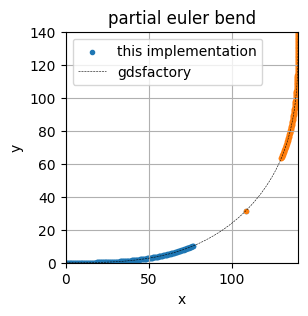

In [ ]:
plt.figure(figsize=(3, 3))
plt.title("partial euler bend")
plt.xlim(0,R_eff)
plt.ylim(0,R_eff)

x, y, radii, angles, l = partial_euler_bend(alpha_tot, p, R_eff)
plt.scatter(x, y, marker = ".", label="this implementation")
plt.scatter(R_eff-y, R_eff-x, marker = ".")

import gdsfactory as gf
pa = gf.path.euler(radius=R_eff, angle=90, p=0.5, use_eff=True, npoints=720)
plt.plot(pa.points[:,0], pa.points[:,1], "k--", linewidth=0.4, label="gdsfactory")

plt.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc="upper left")


# EME assembly

## Straight Geometry

In [ ]:
@lru_cache(maxsize=None)
def create_geometry(L=2.0, w=w, t_core=t_core, t_ox=t_ox, t_slab=t_slab):
    core_ox = mw.Structure(
        material=mw.silicon_oxide,
        geometry=mw.Box(
            x_min=-w / 2 - t_ox / 2,
            x_max=w / 2 + t_ox / 2,
            y_min=0.0,
            y_max=t_core + t_ox,
            z_min=-L / 2,
            z_max=L / 2,
        ),
    )

    slab_ox = mw.Structure(
        material=mw.silicon_oxide,
        geometry=mw.Box(
            x_min=-4,
            x_max=4,
            y_min=-2.0,
            y_max=t_slab + t_ox,
            z_min=-L / 2,
            z_max=L / 2,
        ),
    )

    core = mw.Structure(
        material=mw.silicon,
        geometry=mw.Box(
            x_min=-w / 2,
            x_max=w / 2,
            y_min=0.0,
            y_max=t_core,
            z_min=-L / 2,
            z_max=L / 2,
        ),
    )

    slab = mw.Structure(
        material=mw.silicon,
        geometry=mw.Box(
            x_min=-4,
            x_max=4,
            y_min=0.0,
            y_max=t_slab,
            z_min=-L / 2,
            z_max=L / 2,
        ),
    )

    return [core_ox, slab_ox, core, slab]

In [ ]:
mw.visualize(create_geometry(), scale=(1.0, 1.0, 5.0))

## Cell

In [ ]:
def create_cell(bend_radius, L, w=w, t_core=t_core, t_ox=t_ox, t_slab=t_slab):
    structs = create_geometry(L=L, w=w, t_core=t_core, t_ox=t_ox, t_slab=t_slab)
    cell = mw.Cell(
        structures=structs,
        mesh=mw.Mesh2d(  # decrease approx_dy for more accuracy
            x=_mesh_x(-2.5, 2.5, w, approx_dx=0.05),
            y=_mesh_y(-1.5, 1.5, t_core, approx_dy=0.05),
            bend_radius=bend_radius,
            num_pml=(10, 10),
        ),
        z_min=-L / 2,
        z_max=L / 2,
    )
    return cell


@lru_cache(maxsize=None)
def _mesh_y(start, stop, height_core, approx_dy=0.02):
    """special meshing that makes the pixel boundaries coincide with structure boundaries for better accuracy"""
    num_cells = int(abs(stop - start) / approx_dy + 0.5)
    num_core_cells = int(height_core / approx_dy + 0.5)
    dy = height_core / num_core_cells
    y = np.arange(start, stop, dy)
    idx = np.argmin(abs(y))
    y -= y[idx]
    y = _make_length(y, num_cells)
    # print(y.shape, y[:2] - y[0])
    return y


@lru_cache(maxsize=None)
def _mesh_x(start, stop, width_core, approx_dx=0.02):
    """special meshing that makes the pixel boundaries coincide with structure boundaries for better accuracy"""
    num_cells = int(abs(stop - start) / approx_dx + 0.5)
    num_core_cells = int(width_core / approx_dx + 0.5)
    dx = width_core / num_core_cells
    x = np.arange(start, stop, dx)
    idx = np.argmin(abs(x - width_core / 2))
    x -= x[idx]
    x += width_core / 2
    x = _make_length(x, num_cells)
    # print(x.shape, x[:2] - x[0])
    return x


def _make_length(x, L):
    if x.shape[0] > L:
        return x[:L]
    elif x.shape[0] == L:
        return x
    else:
        dx = x[-1] - x[-2]
        N = L - x.shape[0]
        extra = np.array([x[-1] + (n + 1) * dx for n in range(N)])
        x = np.concatenate([x, extra], 0)
        return x

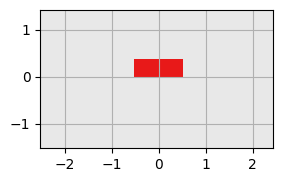

In [ ]:
mw.visualize(create_cell(bend_radius=50.0, L=10))

## Cross Section

We can create a cross section from a cell as follows:

In [ ]:
def create_cross_section(
    bend_radius, L, w=w, t_core=t_core, t_ox=t_ox, t_slab=t_slab, wl=wl_mean, T=T
):
    env = mw.Environment(
        wl=wl,
        T=T,
    )
    cs = mw.CrossSection(
        cell=create_cell(bend_radius, L=L, w=w, t_core=t_core, t_ox=t_ox, t_slab=t_slab),
        env=env,
    )
    return cs

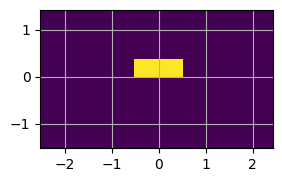

In [ ]:
mw.visualize(create_cross_section(bend_radius=50.0, L=10))

> Note: bend radius is not visualized on cross section visualizations

## Multiple Cross Sections

In [ ]:
def sample_euler_radii(
    num_cells: int, R_eff_min: float, R_eff: float, alpha_tot:float, p:float
):
  """
    sample the euler bend on a equidistant curvature grid.
     Args:
        num_cells: number of samples taken from the curve
        R_eff_min: minimum R_eff for subsequent sweep, to reuse radii/modes
        R_eff: effective Radius for this run
        alpha_tot: angle of the complete partial euler bend
        p: part of bend that is euler (in contrast to circular)
  """

  curvatures = np.linspace(eps,1/R_eff_min, num_cells-3)

  dcurvatures = np.diff(curvatures) #halfinteger grid
  curvatures_ = curvatures[:-1] + dcurvatures/2

  def prepareSlices(curvs):
    radii = 1/curvs
    return partial_euler_bend(alpha_tot, p, R_eff, radii=radii)

  x,y,r,a,l      = prepareSlices(curvatures)
  x_,y_,r_,a_,l_ = prepareSlices(curvatures_)

  return l, r, l_, r_

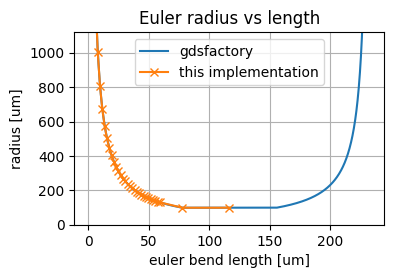

In [ ]:
l, r, l_, r_ = sample_euler_radii(num_cells, R_eff_min, R_eff, alpha_tot, p)
s_gf, curv_gf = pa.curvature()
radii_gf = 1/curv_gf

plt.figure(figsize=(4, 2.5))
plt.title("Euler radius vs length")
plt.plot(s_gf, radii_gf, label="gdsfactory")
plt.plot(l,r, marker="x", label="this implementation")
#plt.xlim(0, R_eff/2)
plt.ylim(0, R_eff*8)
plt.grid(True)
plt.xlabel("euler bend length [um]")
plt.ylabel("radius [um]")
plt.legend()

In [ ]:
def sample_cross_sections(
    num_cells: int, R_eff_min: float, R_eff: float, alpha_tot:float, p:float
):
  l, r, l_, r_ = sample_euler_radii(num_cells, R_eff_min, R_eff, alpha_tot, p)
  Rs = np.concatenate([[1e100], r_, [r[-1]]])  # always good to have a zero-length cell at start and end.
  Ls = np.concatenate([[0], np.diff(l), [0]])  # always good to have a zero-length cell at start and end.
  return [create_cross_section(R, L, wl=wl_mean) for R, L in zip(Rs, Ls)]

## Calculate Modes

In [ ]:
from skill_challenge.util import cMode

In [ ]:
def calculate_modes(
    num_cells: int, R_eff_min: float, R_eff: float, alpha_tot:float, p:float
):
  css = sample_cross_sections(num_cells, R_eff_min, R_eff, alpha_tot, p)
  return [cachedComputeModes(cs, num_modes) for cs in tqdm(css, leave=False)]

In [ ]:
#|eval: false
modes = calculate_modes(num_cells, R_eff_min, R_eff, alpha_tot, p)
for m in modes[0]:
  print(hash(cMode(mode = m)))

  0%|          | 0/35 [00:00<?, ?it/s]

3246172059943435387
8137077869327874689
8002878449715918599
-8095011343712481913
-4363373609266903456
-6971191544164176498
-8907075056116365378


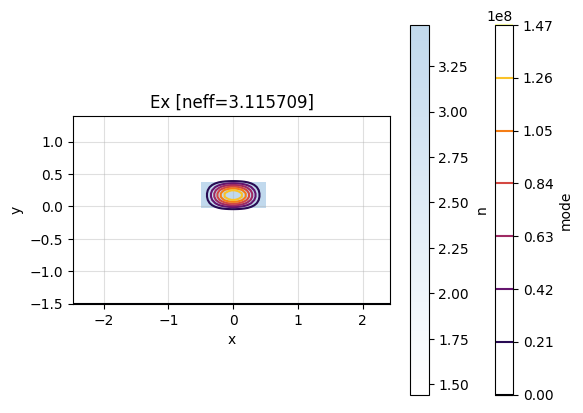

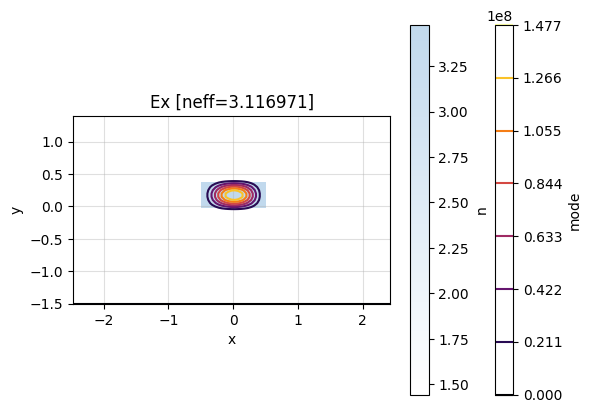

In [ ]:
#|eval: false
mw.visualize(modes[0][0])
mw.visualize(modes[-1][0])

## Calculate S-matrix

In [ ]:
from meow.eme import compute_interface_s_matrix as originalInterface
from typing import Tuple, List
from meow import Mode

@lru_cache(maxsize=None)
def innerInterface( modes1: Tuple[cMode], 
                    modes2: Tuple[cMode], 
                    *args, **kwargs):
  #print("recalculating")
  result = originalInterface(
      [m.getMode() for m in modes1],
      [m.getMode() for m in modes2],
      *args, **kwargs
  )
  return result


def cachedComputeInterfaces(modes: List[List[Mode]], *args, **kwargs):
  """get all the S-matrices of all the interfaces in a collection of `CrossSections`"""
  return {
      f"i_{i}_{i + 1}": cachedSingle(
          modes1=modes1,
          modes2=modes2,
          *args, **kwargs
      )
      for i, (modes1, modes2) in enumerate(zip(modes[:-1], modes[1:]))
  }

def cachedSingle(modes1: List[cMode], 
                 modes2: List[cMode], *args, **kwargs):
  #print("searching cache")
  return innerInterface(
      tuple([cMode(mode=m) for m in modes1]),  
      tuple([cMode(mode=m) for m in modes2]), 
      *args, **kwargs
    )


In [ ]:
#|eval: false
import xarray as xr
from tqdm.notebook import tqdm
results_tot = []
for i, _R_eff in enumerate(tqdm(R_eff_sweep)):
  results_reff = []
  for _p in tqdm(p_sweep, leave=False):
    modes = calculate_modes(num_cells, R_eff_min, _R_eff, alpha_tot, _p)
    S, port_map = mw.compute_s_matrix(modes, compute_interface_s_matrices = cachedComputeInterfaces) #sax_backend="klu"
    results_reff.append(np.abs(S))
  results_tot.append(results_reff)

  results = xr.DataArray(results_tot, dims=("R_eff", "p", "port_in", "port_out"), coords={"R_eff": R_eff_sweep[:i+1], "p": p_sweep})
  results.to_netcdf('euler_sweep_tmp.nc')


# Post Processing

In [ ]:
import xarray, numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
viridis = plt.get_cmap('viridis')
plt.rcParams['figure.figsize'] = (3,2)

In [ ]:
def load_data(suffix):
  return xarray.open_dataarray(f'../assets/euler_sweep{suffix}.nc')

In [ ]:
from scipy.optimize import curve_fit

def power_law(x, k, m):
  return k*np.power(x, m)

def i_power_law(y, k, m):
  return np.power(y/k, 1/m)

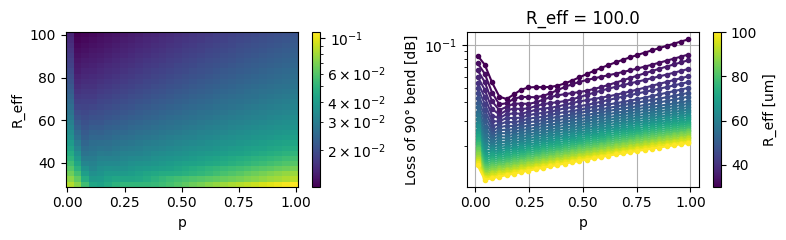

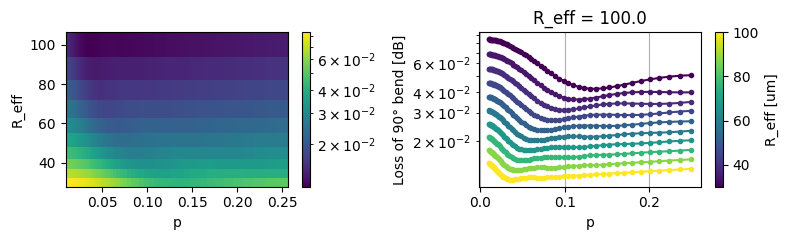

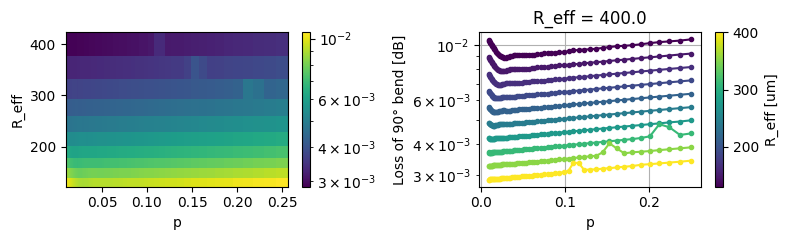

In [ ]:
#@title Optimal p { vertical-output: true}
for suffix in ["1", "2", "3"]:
  try:
    data = load_data(suffix)
    plt.figure(figsize=(8,2.5))
    plt.subplot(121)
    Z = - 2* 20*np.log10(data[:, :, 0,7])
    Z.plot(norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()))

    plt.subplot(122)
    vmin = Z["R_eff"].min()
    vmax = Z["R_eff"].max()
    for z in Z:
      z.plot(color = viridis((z["R_eff"]-vmin)/(vmax-vmin)), marker=".")
    plt.colorbar(
        cm.ScalarMappable(norm=colors.Normalize(vmin=vmin, vmax=vmax), cmap=viridis),
        label = "R_eff [um]",
        ax = plt.gca()
    )
    plt.yscale("log")
    plt.ylabel("Loss of 90° bend [dB]")
    plt.grid()
    plt.tight_layout()
    
  except:
    pass

In [ ]:
d1 = load_data(2)
d2 = load_data(3)
data = xarray.concat([d1, d2], 'R_eff') 
Z = - 2* 20*np.log10(data[:, :, 0,7])

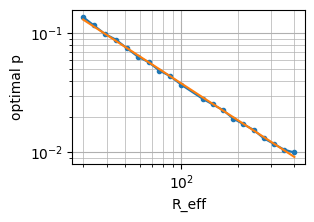

In [ ]:
#@title Optimal p { vertical-output: true}
min_p = Z.idxmin('p')
min_p.plot(marker='.')
plt.loglog()
plt.grid(which="major")
plt.grid(which="minor", linewidth=0.5)
plt.ylabel("optimal p")

popt, _ = curve_fit(power_law, min_p['R_eff'], min_p, sigma=min_p)
R_effs=np.linspace(30, 400)
_ = plt.plot(R_effs, power_law(R_effs, *popt))

The minimum effective radius to reach 0.01dB loss is 117.223um


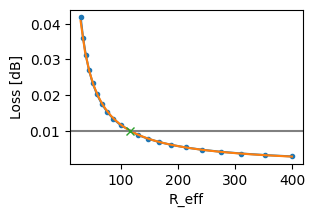

In [ ]:
#@title Minimum R_eff { vertical-output: true}
plt.figure()
min_s = Z.min('p')
min_s.plot(marker='.')

popt, _ = curve_fit(power_law, min_s['R_eff'], min_s, sigma=min_s)
R_effs=np.linspace(30, 400)
plt.plot(R_effs, power_law(R_effs, *popt))
plt.ylabel("Loss [dB]")

loss_opt = 0.01
R_eff_opt = i_power_law(loss_opt, *popt)
plt.axhline(y=loss_opt, color='grey', linestyle='-')
plt.plot([R_eff_opt], [loss_opt], marker="x")
print(f"The minimum effective radius to reach {loss_opt}dB loss is {R_eff_opt:.3f}um")

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()

: 